# Bridge Analysis

This notebook demonstrates the use of `PyCBA` in conducting moving load and other analyses relevant to bridge analysis.

In [1]:
import pycba as cba
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython import display

## Example 1 - Moving Load Envelope

This example shows the basic interface for moving a vehicle across the bridge.

Consider a two-span continuous bridge, 50 m long:

In [2]:
L = [25, 25]
EI = 30 * 1e11 * np.ones(len(L)) * 1e-6
R = [-1, 0, -1, 0, -1, 0]

and a three-axle vehicle with a 6 t steer axle, 6 m spacing back to the tandem of 12 t axles each with spacing 1.2 m:

In [3]:
axle_spacings = np.array([6, 1.2])
axle_weights = np.array([6, 12, 12]) * 9.81  # t to kN

Now define the `bridge_analysis` object and add the bridge definition and vehicle definitions:

In [4]:
bridge_analysis = cba.BridgeAnalysis()
bridge = bridge_analysis.add_bridge(L, EI, R)
vehicle = bridge_analysis.add_vehicle(axle_spacings, axle_weights)

Examine the vehicle at a single position, when the front axle is at 30.0 m say:

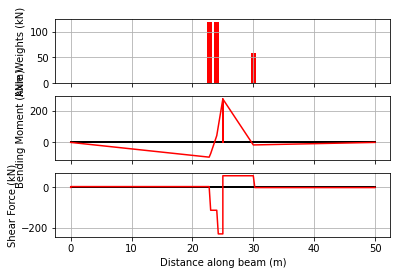

In [5]:
bridge_analysis.static_vehicle(30.0, True);

Now we run the vehicle over the bridge, returning the envelope of results. When run as a python script, the `matplotlib` figure will animate each result when `plot_all=True`.

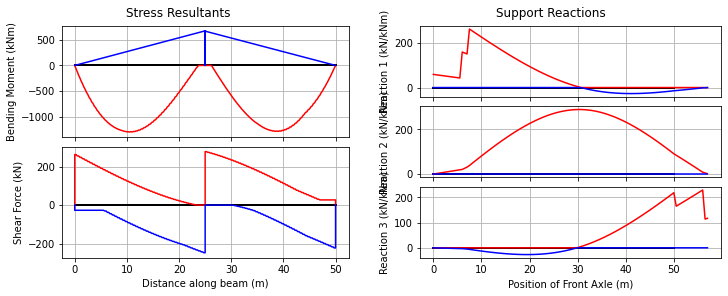

In [6]:
bridge_analysis.run_vehicle(0.5, plot_env=True, plot_all=False);

Alternatively, using the `reverse()` method, we can do an analysis for the vehicle travelling in the reverse direction.

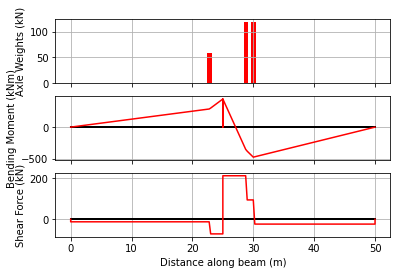

In [7]:
vehicle.reverse()
bridge_analysis.static_vehicle(30.0, True)

## Example 2 - Critical Values and Positions

In [8]:
L = [37]
EI = 30 * 1e11 * np.ones(len(L)) * 1e-6
R = [-1, 0, -1, 0]

In [9]:
bridge = cba.BeamAnalysis(L, EI, R)
bridge.npts = 500  # Use more points along the beam members
vehicle = cba.VehicleLibrary.get_m1600(6.25)
bridge_analysis = cba.BridgeAnalysis(bridge, vehicle)
env = bridge_analysis.run_vehicle(0.1)

From the envelope, we can extract the critical values of load effects, where they are located, and the vehicle position that caused it:

In [10]:
cvals = bridge_analysis.critical_values(env)

and so if we are interested in the maximum bending moment in particular, we can interogate the results as follows:

In [11]:
pos = cvals["Mmax"]["pos"][0]
at = cvals["Mmax"]["at"]
val = cvals["Mmax"]["val"]
print(f"Max moment is {val} kNm at {at:.2f} m when front axle position is {pos} m")

Max moment is 7809.3 kNm at 20.35 m when front axle position is 29.1 m


and confirm the results with a static analysis with the vehicle at that position:

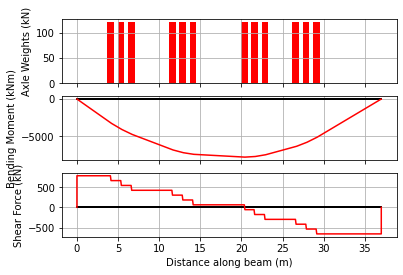

In [12]:
bridge_analysis.static_vehicle(pos, True);

## Example 3 - Critical M1600 Positions

Here we consider the positioning of the M1600 vehicle to obtain maximum bending moment in simply-supported bridges of spans 15 to 40~m

First create the array to store the results and the span lengths.

In [13]:
critical_axle_positions = []
critical_beam_location = []
spans = np.arange(15,40.5,0.5)

Next, create unchanging variables outside the loop, and then loop to find the critical positions:

In [14]:
vehicle = cba.VehicleLibrary.get_m1600(6.25)
for L in spans:
    EI = 30 * 1e11 * 1e-6
    R = [-1, 0, -1, 0]
    bridge = cba.BeamAnalysis([L], EI, R)
    bridge.npts = 500  # Use more points along the beam members    
    bridge_analysis = cba.BridgeAnalysis(bridge, vehicle)
    env = bridge_analysis.run_vehicle(0.05)
    cvals = bridge_analysis.critical_values(env)
    critical_axle_positions.append(cvals["Mmax"]["pos"][0])
    critical_beam_location.append(cvals["Mmax"]["at"])

And plot the results

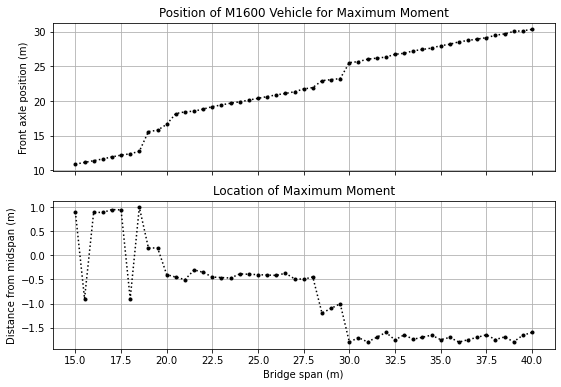

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9,6), sharex=True)
ax1.plot(spans,critical_axle_positions,'k.:')
ax1.grid(which="both")
ax1.set_ylabel("Front axle position (m)")
ax1.set_title("Position of M1600 Vehicle for Maximum Moment");

ax2.plot(spans,spans/2 - critical_beam_location,'k.:')
ax2.grid(which="both")
ax2.set_title("Location of Maximum Moment")
ax2.set_ylabel("Distance from midspan (m)")
ax2.locator_params(axis='x', nbins=12)
ax2.set_xlabel("Bridge span (m)");

## Example 4 - Access Assessment for Single Vehicles

This example considers the relative load effects between a reference vehicle and another vehicle. This type of analysis is commonly done to assess whether a new vehicle type would impose more onerous load effects on a bridge than some existing reference vehicle.

In [16]:
L = [25, 25]
EI = 30 * 1e11 * np.ones(len(L)) * 1e-6
R = [-1, 0, -1, 0, -1, 0]
bridge = cba.BeamAnalysis(L, EI, R)

Here we use a suite of reference vehicles (the Australian ABAG B-doubles) to create a "super-envelope": an envelope of the load effect envelopes from each of the 3 reference vehicles.

Firstly, obtain the vehicle from the `VehicleLibrary` and analyze for the envelope, appending it to the list of envelopes.

In [17]:
envs = []
for i in range(3):
    vehicle = cba.VehicleLibrary.get_abag_bdouble(i)
    bridge_analysis = cba.BridgeAnalysis(bridge, vehicle)
    envs.append(bridge_analysis.run_vehicle(0.5))

Next, create a new zero-like envelope and augment it with the stored envelopes, such that the result is the envelope of envelopes:

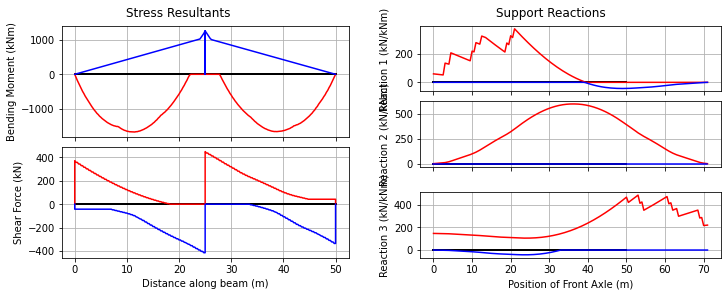

In [18]:
envenv = cba.Envelopes.zero_like(envs[0])
for e in envs:
    envenv.augment(e)
bridge_analysis.plot_envelopes(envenv)

Now analyze the permit application vehicle; here just taking an example vehicle from the `VehicleLibrary`:

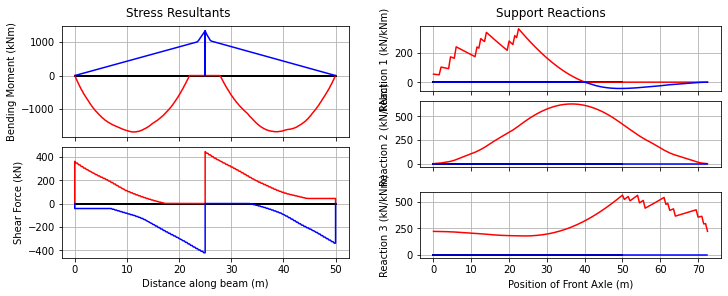

In [19]:
vehicle = cba.VehicleLibrary.get_example_permit()
bridge_analysis = cba.BridgeAnalysis(bridge, vehicle)
trial_env = bridge_analysis.run_vehicle(0.5, True)

And we can plot the ratios of trial to reference envelopes

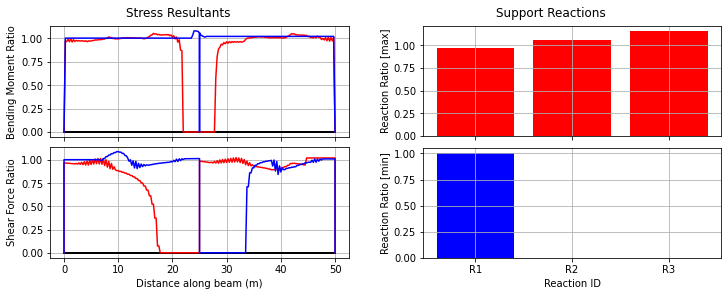

In [20]:
envr = bridge_analysis.envelopes_ratios(trial_env, envenv)
bridge_analysis.plot_ratios(envr)

As can be seen in this case, the central support reaction is greater than 1.0, as is the hogging moment (by about 7%). This vehicle is unlikely to be granted a permit as a result.

## Example 5 - Access Assessment for Vehicle Spacings

Using the `make_train` method we create a `Vehicle` object representing a sequence of vehicles at different spacings. 
Here, we will explore different prime mover and platform trailer combinations commonly adopted in "superload" transport convoys.

First set up the bridge as per Example 3:

In [21]:
L = [25, 25]
EI = 30 * 1e11 * np.ones(len(L)) * 1e-6
R = [-1, 0, -1, 0, -1, 0]
bridge = cba.BeamAnalysis(L, EI, R)

And now define the components of the superload:

In [22]:
prime_mover = cba.Vehicle(axle_spacings=np.array([3.2,1.2]),
                          axle_weights=np.array([6.5,9.25,9.25])*9.81)
platform_trailer = cba.Vehicle(axle_spacings=np.array([1.8,]*9),
                               axle_weights=np.array([12]*10)*9.81)

Three spacing combinations are explored for a convoy comprising of two front prime movers followed by two platform trailers and then two back prime movers.

In [23]:
inter_spaces = [np.array([5.0,6.3,8.0,6.0,4.8]),
               np.array([4.8,6.0,7.5,6.0,5.0]),
               np.array([5.0,6.3,8.0,6.3,5.0])]

Now, similar to Example 3, run the analysis for each set of spacings and store the envelopes:

In [24]:
envs = []
for s in inter_spaces:
    vehicle = cba.make_train([prime_mover]*2 + [platform_trailer]*2 + [prime_mover]*2,spacings=s)
    bridge_analysis = cba.BridgeAnalysis(bridge, vehicle)
    envs.append(bridge_analysis.run_vehicle(0.1))

And now augment the envelopes to get the overall envelope:

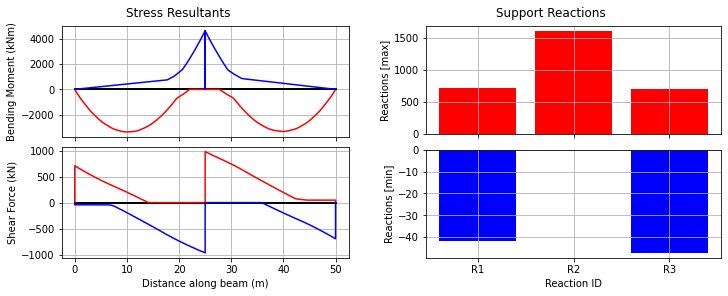

In [25]:
envenv = cba.Envelopes.zero_like(envs[0])
for e in envs:
    envenv.augment(e)
bridge_analysis.plot_envelopes(envenv)

Note that this overall envelope can only show the extremes of reaction values, since the time histories of reactions are not compatible.

## Example 6 - Rail loading

Using the `VehicleLibrary.get_la_rail` method we create a 300LA train load and calculate the values for Appendix C of AS5100.2.

First, create the vehicle using the library method, here the defaults of 300LA, 12m axle-group spacing (centre-to-centre), and 10 No. axle groups (length 150~m) are adequate. Note that we could rationalize the number of axle groups for shorter spans to reduce computation, but this is just a refinement.

In [26]:
vehicle = cba.VehicleLibrary.get_la_rail()

Next create the list of spans we wish to analyse (all simply-supported), and we'll store the results for each span in a list for bending moment, shear, and reactions.

Here we'll just do from 10 to 100~m spans in 10~m increments, but all 99 spans could be done.

In [27]:
spans = np.arange(10,101,10)
M = []
V = []
R = []

Now loop over each span and calculate the load effects

In [28]:
for s in spans:
    L = [s]
    # Simply-supported with arbitrary EI
    bridge = cba.BeamAnalysis(L, 30e6, [-1, 0, -1, 0])
    bridge.npts = 500  # Use more points along the beam
    bridge_analysis = cba.BridgeAnalysis(bridge, vehicle)
    env = bridge_analysis.run_vehicle(0.1)
    cvals = bridge_analysis.critical_values(env)
    m = cvals["Mmax"]["val"]
    v = max(cvals["Vmax"]["val"], abs(cvals["Vmin"]["val"]))
    r = max(cvals["Rmax0"]["val"], cvals["Rmax1"]["val"])
    # now round to nearest 5 as code does
    M.append(round(m / 5) * 5)
    V.append(round(v / 5) * 5)
    R.append(round(r / 5) * 5)

The reason for calculating the shear and reaction is that the vehicle step distance can cause differences. The 0.1~m value selected here is quite small, especially for longer bridges, and so could be different to that used for generating the values in the code. Between the shear and reaction results, the code values should be replicated.

To display the results in a nice way, we use pandas and create a dataframe.

In [29]:
results = list(zip(spans, M, V, R))
columns = ["Span (m)", "Moment (kNm)", "Shear (kN)", "Reaction (kN)"]
df = pd.DataFrame(results,columns=columns,index=spans)

Let's have a look at the results, without showing the redundant index:

In [30]:
df.style.hide()

Span (m),Moment (kNm),Shear (kN),Reaction (kN)
10,2400,1040,1050
20,6300,1515,1530
30,12515,2005,2015
40,21555,2505,2515
50,32560,3015,3025
60,46405,3525,3535
70,62385,4025,4035
80,81045,4525,4535
90,102740,5020,5030
100,126300,5515,5525


## Example 7 - AS5100.2 Appendix C

First we will write a function that accepts a vehicle, loops over a specified span range extracting the critical load effects, and returns a pandas dataframe of the results. We can then use this function for both road and rail.

The function accepts the low and high spans of the range to consider. While the code examines from 1 to 100 m spans, this takes a while to compute, so for the present purposes, facilitate considering a smaller range.

The function also accepts a UDL, necessary for the road bridges. This UDL is applied to the `BeamAnalysis` object and retained in the `BridgeAnalysis` object and applied throughout the vehicle traverse.

We will record both shear and reactions, which can vary slightly due to the step spacing of the load as it traverses the beam.

In [31]:
def critical_effects(vehicle,low_span=1,high_span=100,udl=0):
    spans = np.arange(low_span,high_span+1,1)
    M = []
    V = []
    R = []
    for L in spans:    
        # Simply-supported with arbitrary EI
        bridge = cba.BeamAnalysis([L], 30e6, [-1, 0, -1, 0])
        bridge.npts = 500  # Use more points along the beam
        bridge.add_udl(i_span=1,w=udl)  # Add any UDL
        bridge_analysis = cba.BridgeAnalysis(bridge, vehicle)        
        env = bridge_analysis.run_vehicle(0.1)  # small step
    
        # Extract critical values
        cvals = bridge_analysis.critical_values(env)
        m = cvals["Mmax"]["val"]
        v = max(cvals["Vmax"]["val"], abs(cvals["Vmin"]["val"]))
        r = max(cvals["Rmax0"]["val"], cvals["Rmax1"]["val"])
        
        # now round to nearest 5 as code does
        M.append(round(m / 5) * 5)
        V.append(round(v / 5) * 5)
        R.append(round(r / 5) * 5)

    results = list(zip(spans, M, V, R))
    columns = ["Bridge_length", "m", "v", "r"]
    df = pd.DataFrame(results,columns=columns,index=spans)
    return df

Let's examine the range 40 to 50 m here:

In [32]:
low_span = 40
high_span = 50

First, we examine the road loading in Table C1 of the code, considering the moving and stationary load models seperately:

In [33]:
m1600_vehicle = cba.VehicleLibrary.get_m1600(6.25)
df_m1600 = critical_effects(m1600_vehicle,low_span=low_span,high_span=high_span,udl=6)
df_m1600

,Bridge_length,m,v,r
40,40,10070,1120,1120
41,41,10490,1130,1135
42,42,10910,1145,1150
43,43,11330,1160,1160
44,44,11755,1170,1175
45,45,12180,1180,1185
46,46,12605,1195,1195
47,47,13030,1205,1210
48,48,13465,1215,1220
49,49,13895,1225,1230


In [34]:
s1600_vehicle = cba.VehicleLibrary.get_s1600(6.25)
df_s1600 = critical_effects(s1600_vehicle,low_span=low_span,high_span=high_span,udl=24)
df_s1600

,Bridge_length,m,v,r
40,40,10695,1145,1150
41,41,11180,1165,1165
42,42,11665,1185,1185
43,43,12160,1200,1205
44,44,12660,1220,1220
45,45,13165,1240,1240
46,46,13675,1255,1260
47,47,14195,1275,1275
48,48,14720,1290,1290
49,49,15245,1305,1310


Next, let's examine the 300LA results shown in Table C2 of the code.

In [35]:
rail_vehicle = cba.VehicleLibrary.get_la_rail(axle_weight=300)
df_rail = critical_effects(rail_vehicle,low_span=low_span,high_span=high_span)
df_rail

,Bridge_length,m,v,r
40,40,21555,2505,2515
41,41,22545,2555,2565
42,42,23535,2610,2620
43,43,24520,2665,2675
44,44,25510,2720,2735
45,45,26525,2775,2785
46,46,27590,2825,2840
47,47,28790,2875,2890
48,48,30000,2925,2935
49,49,31270,2970,2980


From the results, it can be seen that the values in the code differ somewhat. Presumably this is because the values in the code were calculated using a coarser increment in the vehicle position for the traverse.